# TP 2-3 : Branch-and-borneSupapplied to a knapsack problem

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-borneSup

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


### Récupération des données

In [2]:
#ne change pas 
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end


readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [3]:

# ADAPTED
function value( var)
    return var.value
end


function TestsSondabilite_LP(model2, BestProfit, Bestsol, resultat_non_trie)
    TA, TO, TR = false, false, false
    # on remplace avec le type enregistrement de la structure model
    if(!model2.feasable)#Test de faisabilite
        TA=true
        println("TA")
    elseif(model2.borneSup<= BestProfit) #Test d'optimalite
        TO=true
        println("TO")
    elseif(model2.degLib==1) #Test de resolution
        TR=true
        println("TR")
        
        
        #if (value(benef) >= BestProfit)
        if (sum([var.value * model2.prices[var.index] for var in model2.variables]) >= BestProfit)
            Bestsol = value.(model2.variables) # la solution best sol sera dans l'ordre décroissant des ratio 
            # il est plus intéressant pour nous d'avoir la solution dans l'ordre des index des objets
            # d'où la création de resultat_non_trie
            BestProfit = sum([var.value * model2.prices[var.index] for var in model2.variables])
            resultat_non_trie= [(var.index) for (index, var) in enumerate(model2.variables) if var.value == 1.0]
            println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")

        end
    else
        println("non sondable")
    end
    TA, TO, TR, Bestsol, BestProfit, resultat_non_trie
end


    

TestsSondabilite_LP (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [4]:
function SeparerNoeud(model2, listobjs, listvals)
   # si le noeud n'est pas sondable on le sépare en deux noeuds
   # On prend la variable qui a le plus grand ratio prix/poids donc le premier libre de la liste des variables
# on va à gauche       
# on la fixe à 1 et on la met dans la liste des variables
    local variable_a_stocker     
        for (i, var) in enumerate(model2.variables)
            # on prend la première variable disponible, comme elles sont triées par ratio décroissant,
            if var.free
                var = model2.variables[i]
                var.free = false
                var.value = 1.0
                model2.degLib-= 1 # on diminue le nombre de degrés de liberté
                variable_a_stocker  = var
                variable_a_stocker  = var
                # on sort de la boucle quand on a trouvé la première variable disponible
                break
            end
        end
    

    push!(listobjs, variable_a_stocker ) #save the identity of the object selected for branching
    push!(listvals, 1.0) #save the node selected, identified by the value assigned to the variable/object chosen

    listobjs, listvals
end


function ExplorerAutreNoeud(model2, listobjs, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible
    
    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)
        obj.free = true
        model2.degLib+= 1

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
            # on libère la variable
            obj.free = true
            model2.degLib+= 1
        end
        # if theval==1.0, we are at the root node, so we stop
        if theval==1.0
            #the root node was sondable
            obj.free = false
            obj.value = 0.0
            model2.degLib-= 1
            push!(listobjs,obj)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    listobjs, listvals, listnodes, stop 
end

ExplorerAutreNoeud (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): <span style="color:red"> SECTION A SUPPRIMER !!!! </span>

<span style="color:red"> Cette section est à commenter/supprimer et remplacer par vos propres calculs de bornes supérieures et autres, par exemple basées sur les bornes 1 et 2 vues en cours, ou d'autres calculs de bornes de votre choix/conception validés au préalable par votre encadrant/e de TP </span>

In [5]:
# implémentation pourl le tp2 

# une variable est définie ainsi:
mutable struct varDecision
    value::Float64  #valeur de la variable
    index::Int64    #indice de la variable
    free::Bool     #indique si la variable est libre ou non
   
end




#Def du modèle
mutable struct myModel
    unsortedVariables::Array{varDecision,1}
    variables::Array{varDecision,1} #liste des variables dans l'ordre décroissant de leur ratio prix/poids
    degLib::Int64 #   
    prices::Array{Int64,1} #liste des prix
    weights::Array{Int64,1} #liste des poids
    capacity::Int64      #capacité du sac
    feasable::Bool #indique si le noeud est faisable ou non
    borneSup::Float64 #borne supérieure du noeud
end

   
    
#calcul la borne supérieure selon la méthode de la borne 1
function relaxationlineaire(model)
    #on s'assure que la capacité est suffisante pour contenir tous les objets
    verif=((model.capacity-(mapreduce(var -> (var.free ? 0. : var.value) * model.weights[var.index], +, model.variables, init = 0))>=10^(-5)))
    residualCapacity = model.capacity - (mapreduce(var -> (var.free ? 0. : var.value) * model.weights[var.index], +, model.variables, init = 0))
    borneSup=-Inf #borne inférieure fixée à -Inf par convention
    if verif 
        # borneSupvaut le profit à cet instant 
        # vaut la borne inférieure 
        borneSup=mapreduce(var -> (var.free ? 0. : var.value) * model.prices[var.index], +, model.variables, init = 0)
        # on calcule la borne supérieure
        for var in model.variables
            if var.free
                borneSup+= residualCapacity * (model.prices[var.index] / model.weights[var.index])
                break
            end
        end
    end
    model.feasable=verif 
    model.borneSup=borneSup# on met à jour la borne supérieure du noeud
end








relaxationlineaire (generic function with 1 method)

In [6]:


# ADAPTED
function CreationModele_LP(price, weight, capacity)
    # ROOT NODE
        
        perm = sortperm(price ./ weight, rev = true)
        N = length(price)
        vars = Array{varDecision, 1}(undef, N)
        for i = 1:N
            vars[i] = varDecision(0.0, i, true)
        end
        model2 = myModel(vars, view(vars, perm), N, price, weight, capacity, false, -Inf)
        
        return model2
    end

CreationModele_LP (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [7]:
function SolveKnapInstance(filename)

    price, weight, capacity = readKnaptxtInstance(filename)
#on enlève le x 
    model2= CreationModele_LP(price, weight, capacity)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
      #intermediate structure to navigate in the search tree
      listobjs=[]
      listvals=[]
      listnodes=[]

    BestProfit=-1
    #cette variable contient les objets  que le sac va contenir dans la solution optimale
    resultat_non_trie=[]
    Bestsol=[]

    current_node_number=0
    stop = false

    while(!stop)

        println("\nNode number ", current_node_number, ": \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)
        # on calcul la borne supérieure
        relaxationlineaire(model2)
        # on regarde si le noeud est sondable
        TA, TO, TR, Bestsol, BestProfit,resultat_non_trie  = TestsSondabilite_LP(model2, BestProfit, Bestsol , resultat_non_trie)
        
        is_node_sondable = TA || TO || TR

        #Reset_LP!(model2, x, listobjs)

        if(!is_node_sondable)
            # le noeud n'est pas sondable, on va créer deux fils
                listobjs, listvals = SeparerNoeud(model2, listobjs, listvals)
        else
            # le noeud est sondable,  on explore son frère 
                listobjs, listvals, listnodes, stop = ExplorerAutreNoeud(model2, listobjs, listvals, listnodes)
        end

        

        current_node_number = current_node_number + 1
    end
    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
    

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes, resultat_non_trie

end

SolveKnapInstance (generic function with 1 method)

### Affichage du résultat final


Node number 0: 
---------------

non sondable

Node number 1: 
---------------

non sondable

Node number 2: 
---------------

TA

Node number 3: 
---------------

non sondable

Node number 4: 
---------------

TR

New Solution memorized [1.0, 0.0, 1.0, 0.0] with bestprofit 65.0


Node number 5: 
---------------

TO

Node number 6: 
---------------

TO

FINISHED

******

Optimal value = 65.0

Optimal x=[1.0, 0.0, 1.0, 0.0]

******

Optimal value = 65.0

Optimal(dans l'ordre croissant des ratio) x=[1.0, 0.0, 1.0, 0.0]
résultat optimal dans l'odre des indices des objets [2, 4]


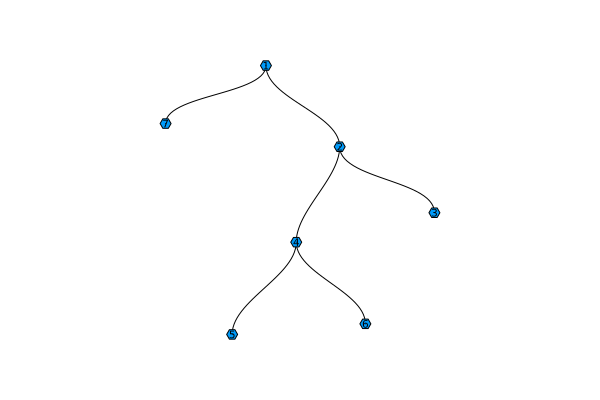

In [15]:
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes, resultat_non_trie = SolveKnapInstance("instancesETU/KNAPnewformat/test.opb.txt")

println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal(dans l'ordre croissant des ratio) x=", Bestsol)
println( "résultat optimal dans l'odre des indices des objets ", resultat_non_trie)

graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)